In [2]:
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
import ulfy
from dolfin import *
from tabulate import tabulate

In [3]:
def pressure_functionspace(mesh, degree, compartments):
    P1 = FiniteElement("CG", mesh.ufl_cell(), degree)
    el = MixedElement([P1] * len(compartments))
    return FunctionSpace(mesh, el)

In [4]:
# Define unit normaal vector of boudnaries.
normals = {1: Constant((-1, 0)), 2: Constant((1, 0)), 3: Constant((0, -1)), 4: Constant((0, 1))}


# Define various subdomains.
subdomains = {1: CompiledSubDomain('near(x[0], -1)'),
              2: CompiledSubDomain('near(x[0], 1)'),
              3: CompiledSubDomain('near(x[1], -1)'),
              4: CompiledSubDomain('near(x[1], 1)')}

compartments = ["e", "pa", "pc", "pv"]


N = 10

# Define MMS Place holders
mesh = RectangleMesh(Point(-1, -1), Point(1, 1), N, N)
x, y = SpatialCoordinate(mesh)

# Prepare coefficients
a = {"e": 0.5, "pa": 1.0, "pc": Constant(0.0), "pv": -1.0}
K = defaultdict(lambda: 1.0)
gamma = defaultdict(lambda: 1.0)
alpha = defaultdict(lambda: 1.0)
p0 = defaultdict(lambda: 0.0)

# Define solutions
p = {j: a[j] * cos(pi * x / 2) * cos(pi * y / 2) + p0[j] for j in compartments}
# p = {j: a[j] * (x**2 + y**2) + p0[j] for j in compartments}


# Define remaining terms
transfer = {j: sum([gamma[(i, j)] * (p[i] - p[j]) for i in compartments if i != j]) for j in compartments}
f = {j: -K[j] * div(grad(p[j])) - transfer[j] for j in compartments}
gR = {j: {tag: alpha[j] * p[j] + K[j] * inner(grad(p[j]), n) for tag, n in normals.items()} for j in compartments}
gN = {j: {tag: -K[j] * inner(grad(p[j]), n) for tag, n in normals.items()} for j in compartments}


expr = lambda v: ulfy.Expression(v, degree=4)  # Here we set it
p_true, f_true = map(lambda v: {j: expr(v[j]) for j in compartments}, (p, f))


for j in gR:
    gR[j] = {tag: expr(gR[j][tag]) for tag in subdomains}

*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
*** Warnin

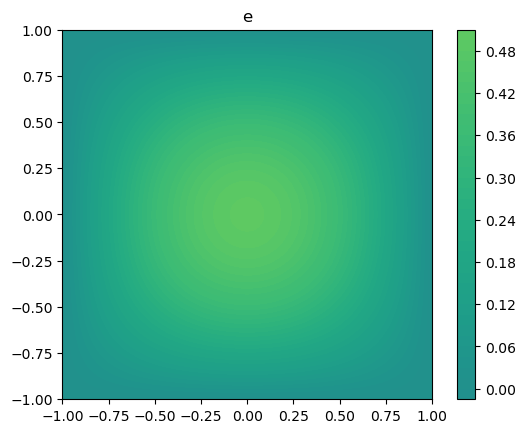

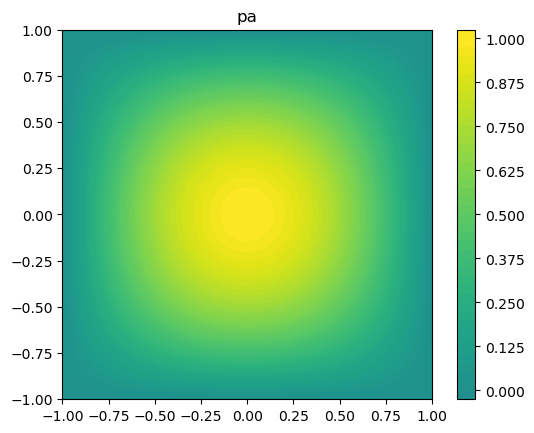

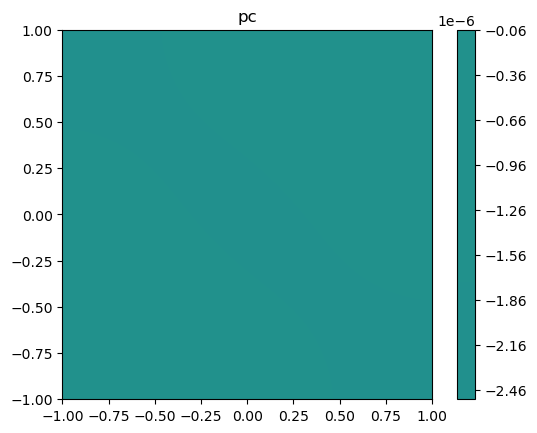

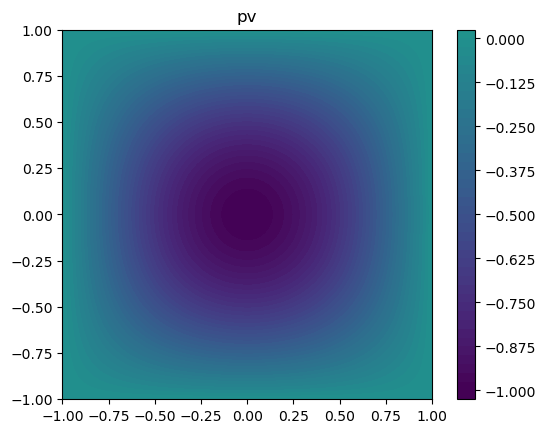

In [4]:
E = []
hvec = []
for N in [0, 1, 2, 3, 4, 5, 6, 7, 8]:
    N = 2**N
    mesh = RectangleMesh(Point(-1, -1), Point(1, 1), N, N)
    
    
    # Define functionspace etc.
    V = pressure_functionspace(mesh, 1, compartments)
    boundaries = MeshFunction('size_t', mesh, 1, 0)
    [subd.mark(boundaries, tag) for tag, subd in subdomains.items()]

    u = TrialFunctions(V)
    v = TestFunction(V)
    ds = Measure('ds', domain=mesh, subdomain_data=boundaries)

    neumann_list = []
    neumann_list = ["pc"]
    F = 0
    for idx, j in enumerate(compartments):
        F += K[j] * inner(grad(u[idx]), grad(v[idx])) * dx
        F -= sum([gamma[(i, j)] * (u[idi] - u[idx]) * v[idx] for idi, i in enumerate(compartments) if i != j]) * dx
        F -= f_true[j] * v[idx] * dx  # Strong form of MMS

        # TODO: prettify
        if j not in neumann_list:
            F += sum([(alpha[j] * u[idx] - gR[j][tag]) * v[idx] * ds(tag) for tag in subdomains])


    a = lhs(F)
    L = rhs(F)
    A = assemble(a)
    b = assemble(L)
    ph = Function(V)
    solve(A, ph.vector(), b)

    vmin = ph.vector().min()
    vmax = ph.vector().max()
    
    E.append(np.sqrt(sum([errornorm(p_true[j], ph.sub(idx), "H1", degree_rise=5)**2 for idx, j in enumerate(compartments)])))
    hvec.append(mesh.hmax())
    
for idx, j in enumerate(compartments):
    t = sum([gamma[(i, j)] * (ph[idi] - ph[idx]) for idi, i in enumerate(compartments) if i != j])
    c = plot(ph.sub(idx), vmin=vmin, vmax=vmax)
    plt.colorbar(c)
    plt.title(j)
    plt.show()

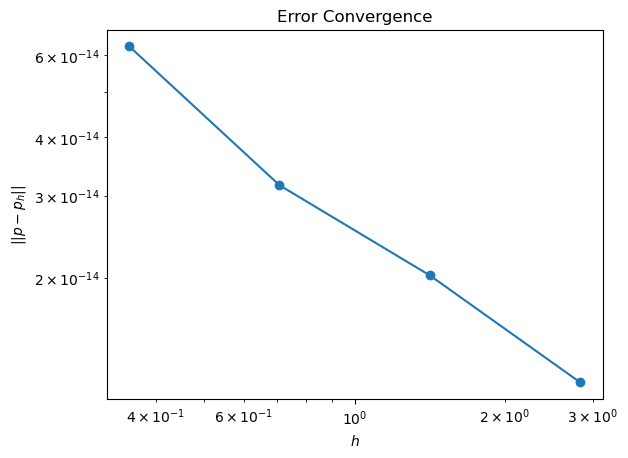

In [15]:
plt.figure()
plt.title("Error Convergence")
plt.loglog(hvec, E, "o-")
plt.xlabel("$h$")
plt.ylabel("$||p - p_h||$")
plt.show()

In [1]:
from collections import defaultdict


import ulfy
import matplotlib.pyplot as plt
import numpy as np
from dolfin import *


from multirat.multicompartment import pressure_functionspace


# Define unit normaal vector of boudnaries.
normals = {1: Constant((-1, 0)), 2: Constant((1, 0)), 3: Constant((0, -1)), 4: Constant((0, 1))}


# Define various subdomains.
subdomains = {1: CompiledSubDomain('near(x[0], -1)'),
              2: CompiledSubDomain('near(x[0], 1)'),
              3: CompiledSubDomain('near(x[1], -1)'),
              4: CompiledSubDomain('near(x[1], 1)')}

compartments = ["e", "pa", "pc", "pv"]


N = 10

# Define MMS Place holders
mesh = RectangleMesh(Point(-1, -1), Point(1, 1), N, N)
x, y = SpatialCoordinate(mesh)

# Prepare coefficients
a = {"e": 0.5, "pa": 1.0, "pc": Constant(0.0), "pv": -1.0}
K = defaultdict(lambda: 1.0)
gamma = defaultdict(lambda: 1.0)
alpha = defaultdict(lambda: 1.0)
p0 = defaultdict(lambda: 0.0)

# Define solutions
p = {j: a[j] * cos(pi * x / 2) * cos(pi * y / 2) + p0[j] for j in compartments}
p = {j: a[j] * (x**2 + y**2) + p0[j] for j in compartments}


# Define remaining terms
transfer = {j: sum([gamma[(i, j)] * (p[i] - p[j]) for i in compartments if i != j]) for j in compartments}
f = {j: -K[j] * div(grad(p[j])) - transfer[j] for j in compartments}
gR = {j: {tag: alpha[j] * p[j] + K[j] * inner(grad(p[j]), n) for tag, n in normals.items()} for j in compartments}
gN = {j: {tag: -K[j] * inner(grad(p[j]), n) for tag, n in normals.items()} for j in compartments}
gD = {j: {tag: p[j] for tag, _ in normals.items()} for j in compartments}



expr = lambda v: ulfy.Expression(v, degree=4)  # Here we set it
p_true, f_true = map(lambda v: {j: expr(v[j]) for j in compartments}, (p, f))

for j in compartments:
    gR[j] = {tag: expr(gR[j][tag]) for tag in subdomains}
    gN[j] = {tag: expr(gN[j][tag]) for tag in subdomains}
    gD[j] = {tag: expr(gD[j][tag]) for tag in subdomains}


# E = []
# hvec = []
# for N in [0, 1, 2, 3, 4, 5, 6]:#, 7, 8]:
#     N = 2**N
#     mesh = RectangleMesh(Point(-1, -1), Point(1, 1), N, N)
    
    
#     # Define functionspace etc.
#     V = pressure_functionspace(mesh, 2, compartments)
#     boundaries = MeshFunction('size_t', mesh, 1, 0)
#     [subd.mark(boundaries, tag) for tag, subd in subdomains.items()]

#     u = TrialFunctions(V)
#     v = TestFunction(V)
#     ds = Measure('ds', domain=mesh, subdomain_data=boundaries)

#     neumann_list = []
#     neumann_list = ["pc"]
#     robin_list = ["e", "pa"]
#     dirichlet_list = ["pv"]
#     F = 0
#     for idx, j in enumerate(compartments):
#         F += K[j] * inner(grad(u[idx]), grad(v[idx])) * dx
#         F -= sum([gamma[(i, j)] * (u[idi] - u[idx]) * v[idx] for idi, i in enumerate(compartments) if i != j]) * dx
#         F -= f_true[j] * v[idx] * dx  # Strong form of MMS

#         # TODO: prettify
#         if j in robin_list:
#             F += sum([(alpha[j] * u[idx] - gR[j][tag]) * v[idx] * ds(tag) for tag in subdomains])
        
#     bcs = {
#         j: [
#             DirichletBC(V.sub(idx), gD[j][tag], boundaries, tag) for tag in subdomains
#         ] for idx, j in enumerate(compartments) if j in dirichlet_list
#     }
#     a = lhs(F)
#     L = rhs(F)
#     A = assemble(a)
#     b = assemble(L)
#     for j in dirichlet_list:
#         for bc in bcs[j]:
#             bc.apply(A, b)

#     ph = Function(V)
#     solve(A, ph.vector(), b)

#     vmin = ph.vector().min()
#     vmax = ph.vector().max()
    
#     E.append(np.sqrt(sum([errornorm(p_true[j], ph.sub(idx), "H1")**2 for idx, j in enumerate(compartments)])))
#     hvec.append(mesh.hmax())
    
for idx, j in enumerate(compartments):
    plt.figure()
    t = sum([gamma[(i, j)] * (ph[idi] - ph[idx]) for idi, i in enumerate(compartments) if i != j])
    c = plot(ph.sub(idx), vmin=vmin, vmax=vmax)
    plt.colorbar(c)
    plt.title(j)
plt.show()


plt.figure()
plt.title("Error Convergence")
plt.loglog(hvec, E, "o-")
plt.xlabel("$h$")
plt.ylabel("$|| p - p_h||$")
plt.show()

NameError: name 'ph' is not defined

<Figure size 640x480 with 0 Axes>

In [25]:
P = Function(V)

In [26]:
def assign_mixed_function(ptrue, V, compartments):
    P = Function(V)
    subspaces = [V.sub(idx).collapse() for idx, _ in enumerate(compartments)]
    Ptrue_int = [interpolate(p_true[j], Vj) for j, Vj in zip(compartments, subspaces)]
    assigner = FunctionAssigner(V, subspaces)
    assigner.assign(P, Ptrue_int)
    return P

In [27]:
P = assign_mixed_function(p_true, V, compartments)

In [31]:
vec = P.vector()[:] - ph.vector()[:]

In [32]:
abs(vec).max()

5.206945985491984e-13

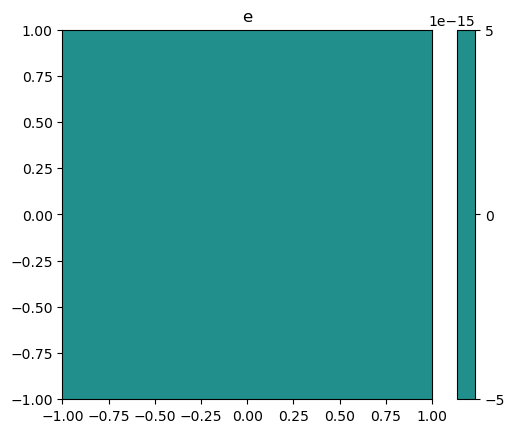

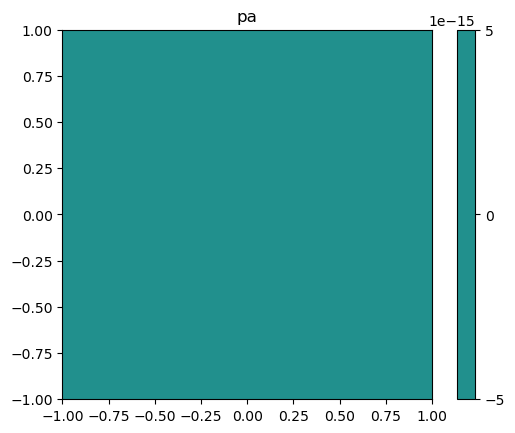

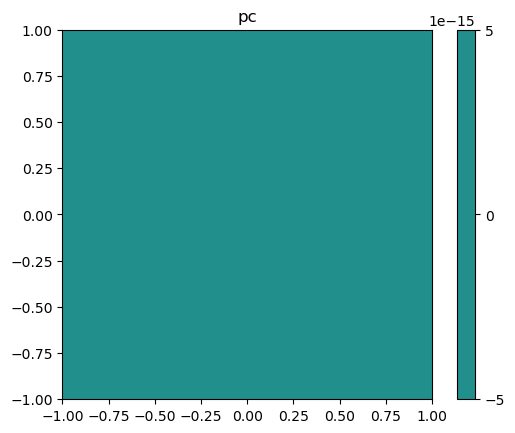

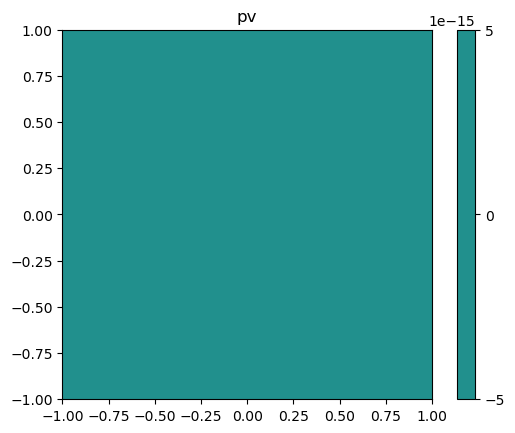

In [10]:
for idx, j in enumerate(compartments):
    plt.figure()
    pint = interpolate(p_true[j], V.sub(idx).collapse())
    P.sub(idx).assign(pint)
   # c = plot(pint, vmin=vmin, vmax=vma
    c = plot(P.sub(idx), vmin=vmin, vmax=vmax)
    plt.colorbar(c)
    plt.title(j)
plt.show()

In [ ]:
c = plot(P.sub(3) - ph.sub(1))
plt.colorbar(c)